#### Capstone Project 20.1: Initial Report and Exploratory Data Analysis (EDA)

![](images/kurt.jpeg)

# **Semiconductor Manufacturing Process Classification**

## Executive Summary
Nowadays, our world is driven by semiconductor chips that power everything from our mobile phones to cars. Being one of the most technologically and highly complicated processes, semiconductor manufacturing have long been studied using machine learning models to increase production.

In this study, semiconductor data collected from manufacturing line are analyzed to detect wafer defects. Five different classification models are constructed to predict the faults during wafer fabrication process. These predictive models are compared againest each other to build the best model for wafer defect predication. 

## Rationale
In modern semiconductor industry, semiconductor wafers undergo a series of processing tools where their electric and physical characteristics can be altered. A wafer is a thin slice of material usually in a round shape with a mirror-like finish surface. 

During wafer fabrication, various types of defects are commonly introduced through the processes of crystal growth, oxidation, diffusion, lithography, etching, deposition, and annealing. At each manufacturing stage, large number of monitoring sensor readings are collected and analyzed. Process engineers need to monitor any unusual defect distribution and take appropriate actions for the corresponding problems. The classification of wafer defect using machine learning models can provide critical information for yield management and facility maintenance.

In addition, the sensor readings collected are not equally valuable. While some of them may contain useful data, others could be just noise. Machine learning techniques of feature selection through dimensionality reduction can be adopted the obtaining of most relevant features to assist process engineers to figure out quickly the root cause of the wafer defects to increase productivity.

## Research Question
The research question this study intends to answer is to find the best way to choose the important monitoring sensor readings and use them to classify the defects. It covers two subjects.

The first subject is how to construct the best machine learning model to effectively predict the occurrence of the wafer defects using the sensor readings collected from the manufacturing process. Different predictive models will be explored in order to achieve the best performance of classification.

The second part is how to select important sensor readings to allow the process engineers to identify of the root causes of the defects in order to manage yield and achieve higher profit.

## Data Sources
The data source I chose to use in this study is from the UCI SECOM Dataset of the link: https://www.kaggle.com/datasets/paresh2047/uci-semcom

This semiconductor dataset contains real sensor readings collected from manufacturing process by at various monitoring and measurement points. These attributes are multivariate in nature which includes total of 591 attributes of 1567 instances.

The target to be classified is inbalanced with 1463 passes and 104 fails, where –1 corresponds to pass and 1 corresponds to fail. The time stamp corresponds to each test points are also included.


In [184]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import VarianceThreshold
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, precision_recall_curve

In [185]:
import warnings
warnings.filterwarnings("ignore")

In [186]:
# Read in UCI Secom dataset
secom_df = pd.read_csv('./data/uci-secom.csv')

In [187]:
secom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


In [188]:
secom_df.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [189]:
# Define column_and_row() 
def column_and_row(df, text): 
    row, column = df.shape
    print(text, column, 'columns and', row, 'rows', )
    
column_and_row(secom_df, "Original dataset contains")

Original dataset contains 592 columns and 1567 rows


In [190]:
# Examine inbalance of data
secom_df['Pass/Fail'].value_counts()

-1    1463
 1     104
Name: Pass/Fail, dtype: int64

## Methodology

### (1) Data Pre-processing

In [191]:
# Drop the 'Time' column and focus on sensor readings data
secom_df = secom_df.drop('Time', axis=1)
#secom_df.info()

In [192]:
# Check the column missing values
secom_df.isna().mean()

# Drop the columns with more than 20% missing values
missing_columns = secom_df.columns[secom_df.isna().mean() >= 0.20]
#print(missing_columns)

secom_df = secom_df.drop(missing_columns, axis=1)
#secom_df.info()

In [193]:
# Fill remaining missing values with column average
for column in secom_df.columns:
    mean = secom_df[column].mean()
    secom_df[column] = secom_df[column].fillna(mean)

secom_df.isna().sum()

0            0
1            0
2            0
3            0
4            0
            ..
586          0
587          0
588          0
589          0
Pass/Fail    0
Length: 559, dtype: int64

In [194]:
# Drop columns with single value 0.0 after scaling
for column in secom_df.columns:
    if len(secom_df[column].unique()) == 1:
        secom_df = secom_df.drop(column, axis=1)

In [195]:
# Replace the 'Pass/Fail' with text labels
secom_df['Pass/Fail'] = secom_df['Pass/Fail'].replace({-1: 'Pass', 1: 'Fail'})

secom_df.head()

,0,1,2,3,4,6,7,8,9,10,...,577,582,583,584,585,586,587,588,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,-0.0034,...,14.9509,0.5005,0.0118,0.0035,2.3630,0.021458,0.016475,0.005283,99.670066,Pass
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,-0.0148,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.009600,0.020100,0.006000,208.204500,Pass
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,0.0013,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.058400,0.048400,0.014800,82.860200,Fail
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,-0.0033,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.020200,0.014900,0.004400,73.843200,Pass
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,-0.0072,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.020200,0.014900,0.004400,73.843200,Pass


In [196]:
## Splitting Train-Test data to make 30% test data
def train_test_split_secom(df):
    X = df.drop(['Pass/Fail'], axis = 1)
    y = df['Pass/Fail']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_secom(secom_df)

In [197]:
# Normalize the data columns to make them in the same range before modeling
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [198]:
X_train_std

,0,1,2,3,4,6,7,8,9,10,...,576,577,582,583,584,585,586,587,588,589
847,-1.130429,0.394423,0.189634,-0.732627,-0.061771,-0.025752,0.006750,1.281510,0.745557,0.714308,...,-0.211022,-0.121791,0.805849,-0.006990,-0.049623,-0.012253,2.331390,1.969732,2.444493,-0.359466
430,-0.786222,1.176964,0.578200,0.076623,-0.054715,0.867808,-0.144210,1.028364,-1.737642,-0.146296,...,-0.237866,0.204560,0.277613,-0.160021,-0.095097,-0.156774,-0.576796,-0.085015,-0.296887,0.091823
1432,-0.190834,-0.184571,-1.245962,-0.805602,-0.059609,-0.098500,0.214319,2.169571,-0.545707,0.649763,...,-0.255062,0.502540,0.336306,-0.155084,-0.072360,-0.153554,-0.455958,0.307465,0.244175,0.207509
398,-0.828798,-2.295522,-0.092089,0.099690,-0.066420,0.639264,0.101099,1.025628,-0.472866,0.154915,...,-0.238184,-0.051780,0.541731,-0.100783,-0.004149,-0.102839,-0.754027,-0.685278,-0.585454,-0.148168
423,0.040861,-2.652499,-0.092089,0.099690,-0.066420,0.639264,0.101099,-0.237362,0.076748,-0.350689,...,-0.264839,-0.020460,-0.426701,-0.061291,-0.049623,-0.058351,-1.680457,-0.558299,-0.549383,-1.056970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,-0.273449,-0.609396,-0.495815,-0.438044,-0.069283,0.800566,-0.068730,-1.400462,1.692483,-0.684174,...,-0.241820,-0.635230,1.422123,-0.120529,-0.186044,-0.124621,0.470473,0.088138,0.063821,-0.399079
1294,0.066086,0.818633,-1.189027,-1.563657,-0.061729,4.669981,0.346409,-1.451091,-1.055590,-0.114023,...,-0.221430,-0.120919,-1.952715,-0.140275,-0.276992,-0.126089,0.204628,-1.123932,-1.090445,-0.768480
860,0.875419,-0.528618,-0.820422,-0.561413,-0.063915,1.014395,0.336974,-0.868173,0.447573,-0.716446,...,-0.211022,-0.603270,-0.426701,-0.332797,-0.254255,-0.321182,0.051565,-0.235081,-0.260817,-0.373366
1459,-0.119431,0.494534,0.018182,0.010634,-0.018333,0.017534,-11.466182,0.249772,1.228953,-0.049478,...,-0.241272,0.049199,-0.749512,-0.224195,-0.117833,-0.213408,-1.970470,0.053507,0.316316,4.662741


In [199]:
# Define a evaluate_model()
def evaluate_model(model, X_test, y_test):
    accuracy = model.score(X_test, y_test)
    
    y_pred = model.predict(X_test)
    
    confusion_mat = confusion_matrix(y_test, y_pred, labels=['Pass', 'Fail'])
         
    classification_rep = classification_report(y_test, y_pred, labels=['Pass', 'Fail'])
    
    print(type(model).__name__)
    print(f'Accurary: {accuracy*100: .2f}%')    
    
    normed_confusion_mat = (confusion_mat.T / confusion_mat.astype(np.float).sum(axis=1)).T
    
    disp = ConfusionMatrixDisplay(confusion_matrix=normed_confusion_mat, display_labels=['Pass', 'Fail'])
    disp.plot()
    plt.show()
    disp.figure_.savefig('images/confusion_matrix.png', dpi=300)
    
    print('Classification Report:\n', classification_rep)

LogisticRegression
Accurary:  90.02%


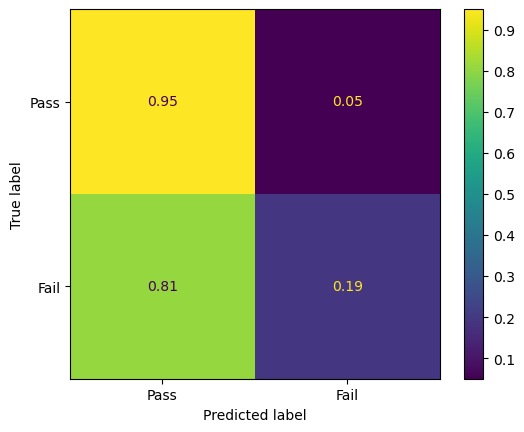

Classification Report:
               precision    recall  f1-score   support

        Pass       0.94      0.95      0.95       440
        Fail       0.21      0.19      0.20        31

    accuracy                           0.90       471
   macro avg       0.58      0.57      0.58       471
weighted avg       0.90      0.90      0.90       471



In [200]:
# Evaluate Logistic Regression model
model = LogisticRegression()
model.fit(X_train_std, y_train)

evaluate_model(model, X_test_std, y_test)

### (2) Feature Selection

In [201]:
# Freature Selection by dropping uncorrelated features 
# Making a copy of the dataset 
secom_df_sel = secom_df.copy() 
secom_df_sel.drop(['Pass/Fail'], axis=1, inplace=True)

# Calculate correlation matrix
corr_matrix = secom_df_sel.corr().abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Get features with correlation greater than 0.75
column_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.70)]

# Drop features that are less correlated
secom_df_sel.drop(column_drop, axis=1, inplace=True)

#secom_df_sel.info()
column_and_row(secom_df_sel, "\nAfter dropping uncorrelated features, dataset contains")


After dropping uncorrelated features, dataset contains 201 columns and 1567 rows


In [202]:
## Feature selection by dropping low variance features
column = secom_df_sel.columns.values

# Use VarianceThreshold()
select = VarianceThreshold(threshold=0.90)
select.fit_transform(secom_df_sel)

features = column[(select.get_support(indices=True))]
secom_df_sel = secom_df_sel.filter(features)

#secom_df_sel.info()
column_and_row(secom_df_sel, "\nAfter dropping low variance features, dataset contains")


After dropping low variance features, dataset contains 94 columns and 1567 rows


In [203]:
secom_df_sel.head()

,0,1,2,3,4,6,12,14,15,16,...,511,521,547,548,550,562,564,570,572,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,202.4396,7.9558,414.8710,10.0433,...,0.0000,0.0,395.570,75.752,12.93,262.729683,6.444985,533.8500,8.95,99.670066
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,200.5470,10.1548,414.7347,9.2599,...,0.0000,0.0,408.798,74.640,16.00,262.729683,6.444985,535.0164,5.92,208.204500
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,202.0179,9.5157,416.7075,9.3144,...,244.2748,0.0,411.136,74.654,16.16,267.064000,1.100000,535.0245,11.21,82.860200
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,201.8482,9.6052,422.2894,9.6924,...,0.0000,0.0,372.822,72.442,131.68,268.228000,7.320000,530.5682,9.33,73.843200
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,201.9424,10.5661,420.5925,10.3387,...,0.0000,0.0,399.914,79.156,19.63,262.729683,6.444985,532.0155,8.83,73.843200


In [204]:
secom_df

,0,1,2,3,4,6,7,8,9,10,...,577,582,583,584,585,586,587,588,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.500500,0.016200,-0.003400,...,14.9509,0.5005,0.0118,0.0035,2.3630,0.021458,0.016475,0.005283,99.670066,Pass
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.496600,-0.000500,-0.014800,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.009600,0.020100,0.006000,208.204500,Pass
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.443600,0.004100,0.001300,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.058400,0.048400,0.014800,82.860200,Fail
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.488200,-0.012400,-0.003300,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.020200,0.014900,0.004400,73.843200,Pass
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.503100,-0.003100,-0.007200,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.020200,0.014900,0.004400,73.843200,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2899.41,2464.36,2179.7333,3085.3781,1.4843,82.2467,0.1248,1.342400,-0.004500,-0.005700,...,11.7256,0.4988,0.0143,0.0039,2.8669,0.006800,0.013800,0.004700,203.172000,Pass
1563,3052.31,2522.55,2198.5667,1124.6595,0.8763,98.4689,0.1205,1.433300,-0.006100,-0.009300,...,17.8379,0.4975,0.0131,0.0036,2.6238,0.006800,0.013800,0.004700,203.172000,Pass
1564,2978.81,2379.78,2206.3000,1110.4967,0.8236,99.4122,0.1208,1.462862,-0.000841,0.000146,...,17.7267,0.4987,0.0153,0.0041,3.0590,0.019700,0.008600,0.002500,43.523100,Pass
1565,2894.92,2532.01,2177.0333,1183.7287,1.5726,98.7978,0.1213,1.462200,-0.007200,0.003200,...,19.2104,0.5004,0.0178,0.0038,3.5662,0.026200,0.024500,0.007500,93.494100,Pass


In [205]:
# Split trian and test of data after feature selection
secom_df_sel['Pass/Fail'] = secom_df['Pass/Fail'].map({'Pass': -1, 'Fail': 1})
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split_secom(secom_df_sel)

In [206]:
y_test_sel 

548    -1
664    -1
730    -1
405    -1
175    -1
       ..
481    -1
435    -1
1555   -1
1453   -1
308    -1
Name: Pass/Fail, Length: 471, dtype: int64

In [207]:
# Normalize the data columns to make them in the same range before modeling
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

### (3) Model Construction

In [208]:
# Define model_grid_search()
def model_grid_search(model, params): 
    best_model = None
    best_mse = np.inf
    
    grid = GridSearchCV(model, param_grid=params)
    grid.fit(X_train_sel, y_train_sel)
    
    print(grid.best_params_)
    print(grid.score(X_test_sel, y_test_sel)) 

In [209]:
# Logistic Regression
params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }  
lgr = LogisticRegression(penalty='l2')

model_grid_search(lgr, params_grid)

{'C': 1}
0.9256900212314225


In [210]:
# Test MSE of Logistic Regression 
best_lgr = LogisticRegression(C=1, penalty='l2').fit(X_train_sel, y_train_sel)

test_mse_lgr = mean_squared_error(best_lgr.predict(X_test_sel), y_test_sel)
test_accuracy_lgr = best_lgr.score(X_test_sel, y_test_sel)    

print(f'LogisticRegression Test MSE: {test_mse_lgr: .2f}, Test_Accurary: {test_accuracy_lgr: .2f}')  

LogisticRegression Test MSE:  0.30, Test_Accurary:  0.93


In [211]:
# SVM
params_grid = {'gamma': [0.001, 0.01, 0.1, 1.0]}     
svc = SVC()

model_grid_search(svc, params_grid)

{'gamma': 0.001}
0.9341825902335457


In [212]:
# Test MSE of SVM 
best_svm = SVC(gamma=0.001).fit(X_train_sel, y_train_sel)

test_mse_svm = mean_squared_error(best_svm.predict(X_test_sel), y_test_sel)
test_accuracy_svm = best_svm.score(X_test_sel, y_test_sel)    

print(f'SVM Test MSE: {test_mse_svm: .2f}, Test_Accurary: {test_accuracy_svm: .2f}')  

SVM Test MSE:  0.26, Test_Accurary:  0.93


In [213]:
# KNN
params_grid = {'n_neighbors': [3, 5, 7]}
knn = KNeighborsClassifier()

model_grid_search(knn, params_grid)

{'n_neighbors': 5}
0.9299363057324841


In [214]:
# Test MSE of KNN 
best_knn = KNeighborsClassifier(n_neighbors = 5).fit(X_train_sel, y_train_sel)

test_mse_knn = mean_squared_error(best_knn.predict(X_test_sel), y_test_sel)
test_accuracy_knn = best_knn.score(X_test_sel, y_test_sel)    

print(f'KNN Test MSE: {test_mse_knn: .2f}, Test_Accurary: {test_accuracy_knn: .2f}')  

KNN Test MSE:  0.28, Test_Accurary:  0.93


In [215]:
# Decision Tree
params_grid = {"max_depth": [3, 5, 7]}
dtree = DecisionTreeClassifier()

model_grid_search(dtree, params_grid)

{'max_depth': 3}
0.9278131634819533


In [216]:
# Test MSE of Decision Tree
best_dtree = DecisionTreeClassifier(max_depth = 3).fit(X_train_sel, y_train_sel)

test_mse_dtree = mean_squared_error(best_dtree.predict(X_test_sel), y_test_sel)
test_accuracy_dtree = best_dtree.score(X_test_sel, y_test_sel)    

print(f'Decision Tree Test MSE: {test_mse_dtree: .2f}, Test_Accurary: {test_accuracy_dtree: .2f}')  

Decision Tree Test MSE:  0.29, Test_Accurary:  0.93


In [217]:
# Test MSE of Naive Bayes 
pipe_nb = Pipeline([('Normalizing', MinMaxScaler()), ('MultinomialNB', MultinomialNB())])
pipe_nb.fit(X_train_sel, y_train_sel) 

test_mse_nb = mean_squared_error(pipe_nb.predict(X_test_sel), y_test_sel)
test_accuracy_nb= pipe_nb.score(X_test_sel, y_test_sel)    

print(f'Naive Bayes Test MSE: {test_mse_nb: .2f}, Test_Accurary: {test_accuracy_nb: .2f}')  

Naive Bayes Test MSE:  0.26, Test_Accurary:  0.93


In [218]:
model_df = pd.DataFrame({'model': ['Logistic Regression', 'SVM', 'KNN', 'Decision Tree', 'Naive Bayes'], 
             'test_mse': [test_mse_lgr, test_mse_svm, test_mse_knn, test_mse_dtree, test_mse_nb],
             'test_accuracy': [test_accuracy_lgr, test_accuracy_svm, test_accuracy_knn, test_accuracy_dtree, test_accuracy_nb]}).set_index('model')

model_df

,test_mse,test_accuracy
model,,
Logistic Regression,0.297240,0.925690
SVM,0.263270,0.934183
KNN,0.280255,0.929936
Decision Tree,0.288747,0.927813
Naive Bayes,0.263270,0.934183


In [219]:
print(f'Select the low MSE and high accurary, SVM and Naive Bayes are the two winners!')  

Select the low MSE and high accurary, SVM and Naive Bayes are the two winners!


## Results

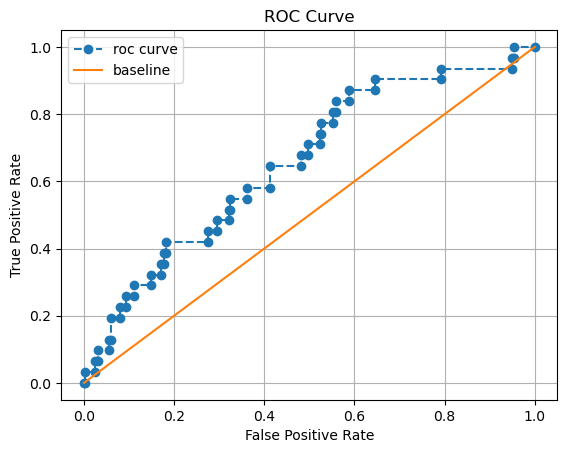

In [220]:
# Visualize the ROC curve
fpr, tpr, thresh_rocs = roc_curve(y_test_sel, test_predictions[:, 1], pos_label = 1)

plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();
plt.savefig('images/roc_curve.png', dpi=200)

In [221]:
# Apply the best model for fitting
pipe_nb = Pipeline([('Normalizing', MinMaxScaler()), ('MultinomialNB', MultinomialNB())])
pipe_nb.fit(X_train_sel, y_train_sel) 

test_mse_nb = mean_squared_error(pipe_nb.predict(X_test_sel), y_test_sel)
test_accuracy_nb= pipe_nb.score(X_test_sel, y_test_sel)    

In [223]:
# Find out the permutation importance
r = permutation_importance(pipe_nb, X_test_sel, y_test_sel,
                            n_repeats=10,
                            random_state=2)

# Top 10 most-important features
print('The top 10 most-important features are:')
for i, j in zip(r.importances_mean.argsort()[::-1], range(0,11)):
     if r.importances_mean[i] - 2 * r.importances_std[i] >= 0:
        print(f"{X_test_sel.columns[i]:<0.5}")

The top 10 most-important features are:
589
129
63
64
68
71
88
90
115
117


## Next Steps

For next steps, I plan to make improvements from four different areas to achieve higher model performance:

(1) Refine feature selection by exploring other techniques of vector classifier and PCA.

(2) Adopt over-sampling methods such as SMOTE to handle imbalanced data classification

(3) Enhance classification models by examining other classifiers such as random forest 

(4) Clean code and make the work presentable for technical and non-technical audiences